# 프로젝트 : 주식 예측에 도전해 보자

익스에서 최소한 3종목 이상의 주식 예측해야함, p, d, q 어떤 사고 과정을 통해 선택했는지 서술하는게 중요! => 각 p,d,q 값에 따른 mape를 출력해야함!
야후에서 1년치 그래프만 다운받아 분석, 등락이 적은 그래프가 모델이 예측하기 좋음 

**루브릭**

1. 시계열의 안정성이 충분히 확인되었는가?    
플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?        
p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?    
3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

# 1. 삼성전자

In [3]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


## STEP 1 : 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

#### os.getenv() : 특정 환경변수 값 얻기, 'HOME'을 넣으면, 내 'HOME'어 저장되어있는 값을 읽을 수있다. 
#### index_col='Date' : Date 컬럼을 인덱스로 삼겠다.    
#### parse_dates=True : 해당 날짜를 datetime으로 변경하겠다. 

#### 주피터를 껐다 다시 실행했더니 파일이 안 불러와지는 문제가 생겨서, 퍼실님들께 여쭤보고 한참 헤매다 파일을 다운 받았다. 
#### 파일을 다시 받아서 해결된 줄 알았는데, 노드를 이동하면 같은 문제가 반복되었다. 
#### stock_predicton 폴더에 있는 파일은 전부 404 Error가 생겨 다른 폴더에 새로 업로드해서 해결했다. 

REF)     
https://algopoolja.tistory.com/46 환경변수의 종류와 목적 

# STEP 2 : 각종 전처리 수행

- 결측치 처리
- 로그 변환

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

#### 결측치는 없다.  

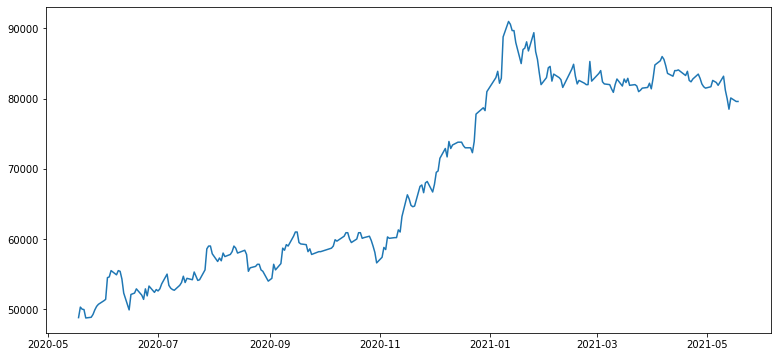

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6   

plt.plot(ts)

In [7]:
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

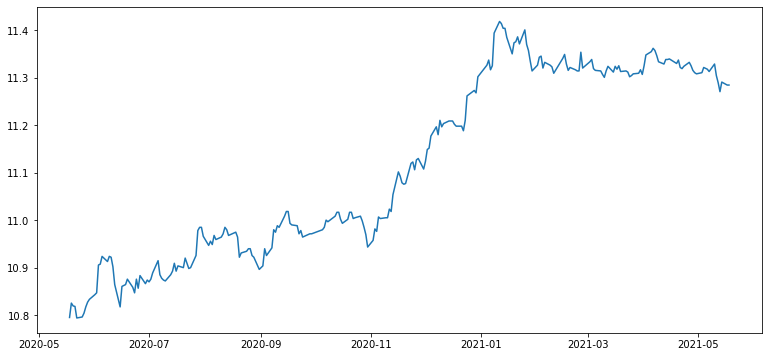

In [8]:
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인    

#### 정성적 분석(Qualitative Analysis) : 숫자가 아니라 말로 설명하는 분석, 물질의 성분이나 성질을 밝히기 위한 분석
#### 정량적 분석(Quantitative Analysis) : 숫자로 측정하고 표현하는 분석, 성분과 성질의 양적 관계를 밝히기 위한 분석 

REF)    
https://infuture.kr/426

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('주식왕이될 준비 1단계 완료!')

주식왕이될 준비 1단계 완료!


In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('주식왕이될 준비 2단계 완료!')

주식왕이될 준비 2단계 완료!


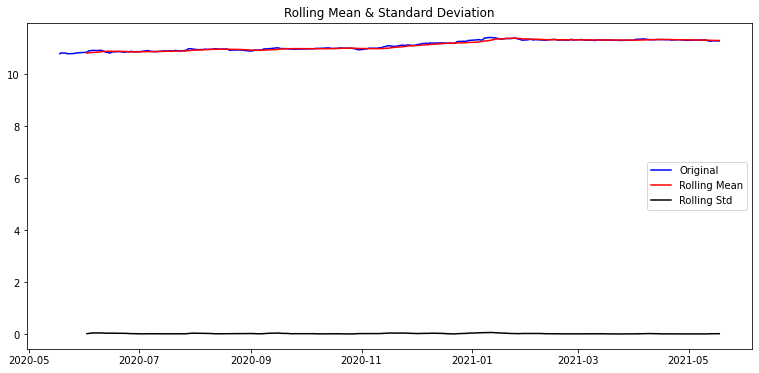

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


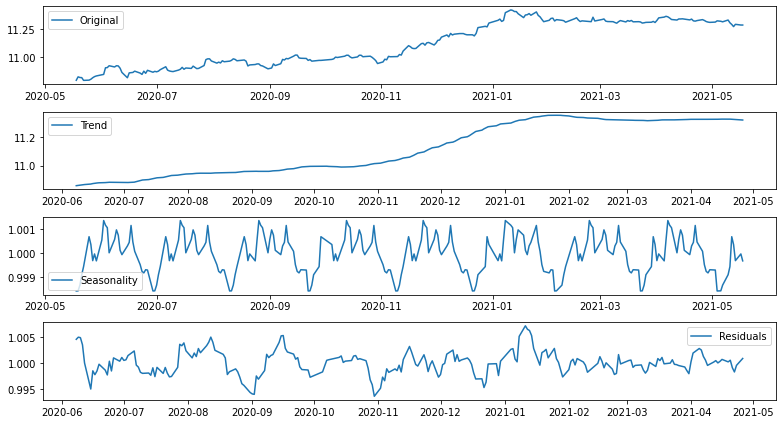

In [11]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


#### 코드를 노드대로 따왔더니 NameError: name 'plot_rolling_statistics' is not defined 에러가 나왔다. 
#### plot rolling statistics와, augmented dickey_fuller test를 정의하는 코드를 넣어주었다. 
#### P-Value가 0.5가 나왔다. 귀무가설을 기각할 정도는 아니지만, 이 시계열이 안정적이라고 말할 수는 없다. 
 
REF) Fundamental 41-3    
p-value는 0~1사이의 값으로, 1 가까울수록 통계치가 귀무가설과 양립함, 대립가설 채택하기 위한 마지노선(유의 수준)은 0.05나 0.01

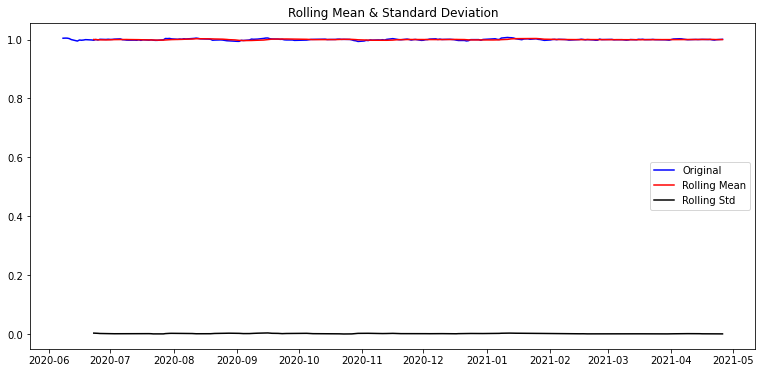

In [12]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [13]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


#### 시계열 분해 후 얻은 Residual의 p-value은 6.234854e-08로 매우 낮다. 예측 가능한 수준의 안정적인 시계열이라고 판단할 수 있다. 
#### inplace=True : dropna가 적용된 DataFrame 자체에 dropna를 적용
REF)     
https://cosmosproject.tistory.com/308 dropna 파라미터 

## STEP 4 : 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

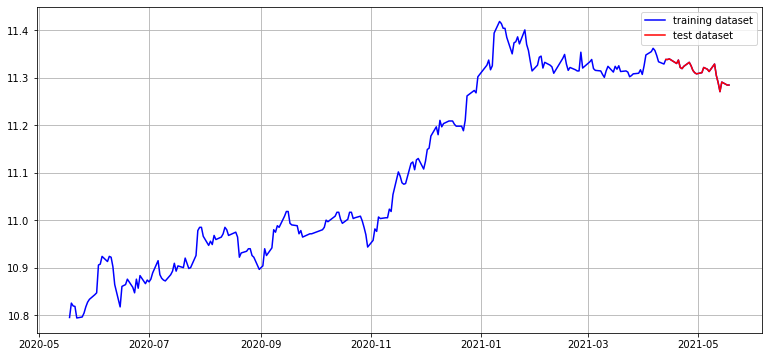

In [51]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure()
plt.grid(True)
plt.plot(ts_log, c='b', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='r', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

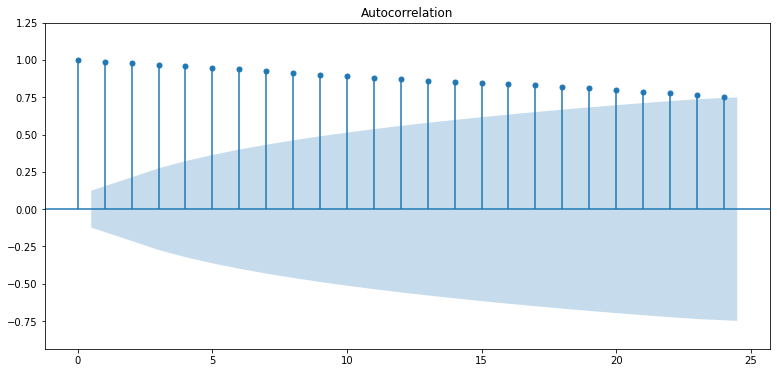

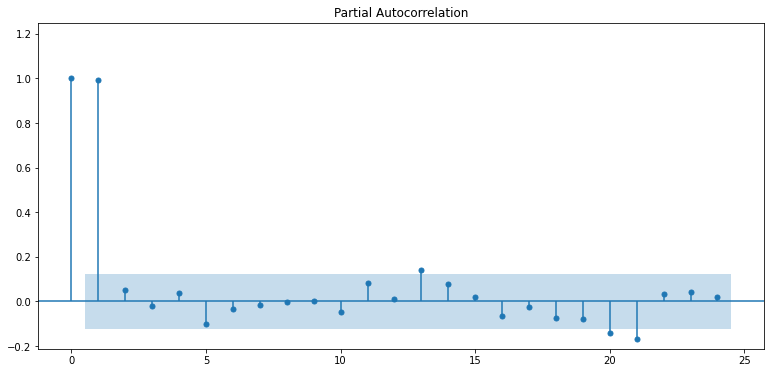

In [15]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore') 

plot_acf(ts_log, auto_ylims= True)   
plot_pacf(ts_log, auto_ylims= True) 
plt.show()

#### ACF 그래프는 lag 1~22까지가 음영 밖으로 나와 유의미한 값을 보이지만, 그래프가 전반적으로 찬찬히 줄어들기 때문에 q값에 0을 넣는게 낫다. 
#### PACF 그래프는 lag 1에서 유의미한 값을 보인다. lag 13, 21에서도 음영 밖으로 나와있지만, 너무 조금이라 크게 의미는 없다. 
#### method='ywm'경고가 나와 경고를 없애는 모듈 코드를 넣었다. 
#### 소명님 조언대로 auto_ylims= True를 넣으니 그래프 윗 부분이 짤리지 않아 깔끔하게 보인다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


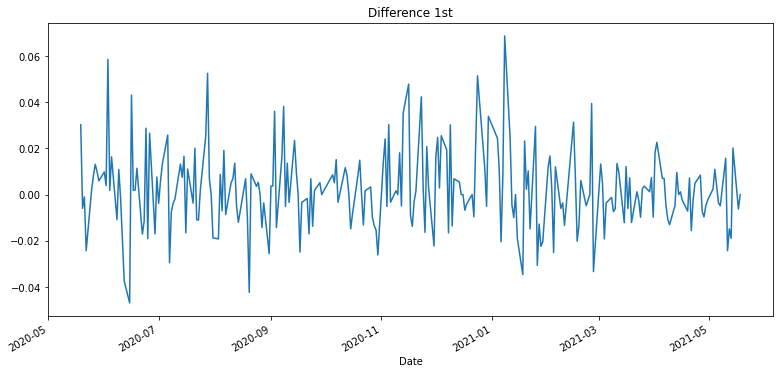

In [16]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


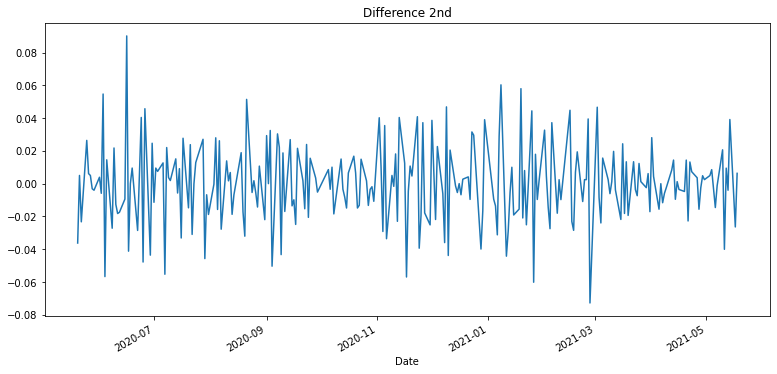

In [17]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 1차 차분으로 p-value가 2.183738e-28로 나와 데이터가 안정되었다. 그러나 2차 차분을 해보았더니 오히려 p-value값이 높아졌다.  d값은 1을 넣는게 낫겠다. 

## STEP 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [52]:
from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(train_data, order=(1,1,0))
model2 = ARIMA(train_data, order=(0,1,0))
model3 = ARIMA(train_data, order=(2,1,0))
model4 = ARIMA(train_data, order=(21,1,0))

res1 = model1.fit()
res2 = model2.fit()
res3 = model3.fit()
res4 = model4.fit()

#### ACF, PACF, 차분을 통해 얻은 값을 모델 네 가지에 나누어 넣었다. 

In [53]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Thu, 05 Jan 2023   AIC                          -1162.976
Time:                        12:01:45   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                21.07
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.52
Prob(H) (two-sided):                  0.87   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Thu, 05 Jan 2023   AIC                          -1164.726
Time:                        12:01:51   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.52
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 583.501
Date:                Thu, 05 Jan 2023   AIC                          -1161.003
Time:                        12:01:53   BIC                          -1150.768
Sample:                             0   HQIC                         -1156.871
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0367      0.062      0.592      0.554      -0.085       0.158
ar.L2         -0.0112      0.076     -0.147      0.883      -0.160       0.138
sigma2         0.0003   2.47e-05     12.961      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                20.53
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.52
Prob(H) (two-sided):                  0.86   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(21, 1, 0)   Log Likelihood                 589.436
Date:                Thu, 05 Jan 2023   AIC                          -1134.873
Time:                        12:01:54   BIC                          -1059.817
Sample:                             0   HQIC                         -1104.576
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0378      0.070      0.536      0.592      -0.100       0.176
ar.L2         -0.0205      0.082     -0.249      0.803      -0.182       0.141
ar.L3         -0.0418      0.083     -0.507      0.612      -0.204       0.120
ar.L4          0.0317      0.089      0.357      0.721      -0.142       0.205
ar.L5         -0.0046      0.075     -0.061      0.951      -0.151       0.142
ar.L6          0.0107      0.075      0.142      0.887      -0.136       0.158
ar.L7          0.0666      0.064      1.035      0.301      -0.060       0.193
ar.L8          0.0080      0.067      0.121      0.904      -0.122       0.138
ar.L9          0.0861      0.069      1.242      0.214      -0.050       0.222
ar.L10        -0.1002      0.078     -1.283      0.199      -0.253       0.053
ar.L11         0.0241      0.077      0.314      0.753      -0.126       0.175
ar.L12        -0.0023      0.075     -0.031      0.975      -0.149       0.144
ar.L13        -0.1239      0.082     -1.514      0.130      -0.284       0.036
ar.L14        -0.0011      0.080     -0.013      0.989      -0.159       0.157
ar.L15         0.0319      0.068      0.471      0.638      -0.101       0.165
ar.L16         0.0239      0.073      0.327      0.744      -0.120       0.167
ar.L17         0.1004      0.088      1.147      0.251      -0.071       0.272
ar.L18        -0.0196      0.086     -0.228      0.820      -0.189       0.149
ar.L19         0.0330      0.081      0.409      0.682      -0.125       0.191
ar.L20         0.0417      0.084      0.497      0.619      -0.123       0.206
ar.L21         0.0714      0.083      0.857      0.391      -0.092       0.235
sigma2         0.0003   2.62e-05     11.522      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                14.31
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.32
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Auto-Arima를 돌렸더니 (0, 1, 0)이 나왔었다. ACF, PACF로 판단한 값 보다, (0, 1, 0)을 넣은 res2가 가장 낮은 AIC값이 나왔다. 

In [57]:
# Forecast : 결과가 fc에 담깁니다.
fc1 = res1.forecast(len(test_data), alpha=0.05)
fc2 = res2.forecast(len(test_data), alpha=0.05)
fc3 = res3.forecast(len(test_data), alpha=0.05) 
fc4 = res4.forecast(len(test_data), alpha=0.05) 

fc1 = np.array(fc1)
fc2 = np.array(fc2)
fc3 = np.array(fc3)
fc4 = np.array(fc4)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 

mape1 = np.mean(np.abs(np.exp(fc1) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape4 = np.mean(np.abs(np.exp(fc4) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('(1,1,0)일 때 MAPE: {:.2f}%'.format(mape1*100))
print('(0,1,0)일 때 MAPE: {:.2f}%'.format(mape2*100))
print('(2,1,0)일 때 MAPE: {:.2f}%'.format(mape3*100))
print('(21,1,0)일 때 MAPE: {:.2f}%'.format(mape4*100))

(1,1,0)일 때 MAPE: 1.74%
(0,1,0)일 때 MAPE: 1.74%
(2,1,0)일 때 MAPE: 1.74%
(21,1,0)일 때 MAPE: 1.77%


#### AIC는 (0, 1, 0)이 가장 낮게 나왔지만, MAPE 값은 거의 차이가 없다. 

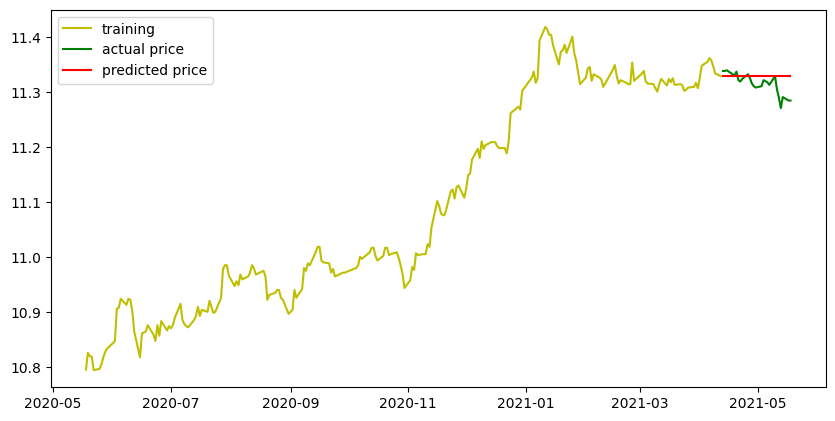

In [60]:
# Make as pandas series
fc2_series = pd.Series(fc2, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, c='y',label='training')
plt.plot(test_data, c='g', label='actual price')
plt.plot(fc2_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [61]:
print('(0,1,0)일 때')
mse = mean_squared_error(np.exp(test_data), np.exp(fc2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc2) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

(0,1,0)일 때
MSE:  3509600.000000066
MAE:  1408.0000000000023
RMSE:  1873.3926443754567
MAPE: 1.74%


## STEP 7 : 다른 주식 종목 예측해 보기

- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

In [ ]:
dataset_filepath = os.getenv('HOME') + '/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

## 회고 

#### 헤맸던 것
- log 취한 데이터로 이동평균과 이동표준편차 그래프를 구현하니 너무 밋밋하게 나와서, 이게 맞는건지 한참 헤맸다. 
- 노드를 바꾸고 주피터를 재실행했더니, 데이터 원본에 404에러가 생겨 해결하는데 시간이 많이 허비되었다. 
- ARIMA 모델을 차분한 diffed 변수로 돌려 MAPE가 1이 나왔다. 나중에 발견해 train_data로 전부 바꿨다.

#### 새롭게 알게된 것
- 원본 데이터는 애초에 다운받아서 가지고 있는게 안전하다.
- 차분을 더 한다고 꼭 p-value가 낮아지는건 아니다. 
- AIC 값에 차이가 있어도, 그 차이가 미미하면 MAPE는 똑같이 나올 수 있다.  

#### 아직도 모르는 것
- Rolling Mean & Standard Deviation 그래프를 어떻게 해석해야할지 모르겠다. 
- ACF, PACF 그래프의 음영이 유의수준을 나타낸다는 것은 알겠는데, lag에 따라 음영이 바뀌는 것은 무슨 의미인지 모르겠다. 
- MAPE를 더 낮출 방법을 모르겠다. 